# MDS Movies for Embeddings Over Time

This notebook provides a function to create MDS (Multi-Dimensional Scaling) movies from embeddings that vary over time. The function takes embeddings or RDMs (Representational Dissimilarity Matrices) as input and creates animated visualizations showing how the embedding space evolves over time.

## What This Does

1. **MDS per time frame**: Computes MDS coordinates for each time point
2. **Procrustes alignment**: Aligns all frames to a reference frame (removes rotation/translation, keeps structure)
3. **Animation**: Creates a movie showing how embeddings move through the 2D MDS space over time
4. **Color-coding**: Can color-code points based on labels (e.g., categories, classes)

## Key Concepts

### MDS (Multi-Dimensional Scaling)
MDS is a dimensionality reduction technique that takes a **distance matrix** (how far apart each pair of items is) and finds coordinates in a lower-dimensional space that preserve those distances as well as possible.

- **Input**: Distance matrix D (N×N) where D[i,j] = distance between item i and item j
- **Output**: Coordinates X (N×k) in k-dimensional space
- **Goal**: Preserve pairwise distances in the lower-dimensional space

### Procrustes Alignment
When you compute MDS for each time frame separately, the coordinate systems are arbitrary (can be rotated, flipped, translated). Procrustes alignment:

- **Aligns** all frames to a reference frame
- **Removes** rotation and translation (but NOT scaling - we use "no scaling" version)
- **Preserves** the relative structure/distances
- **Result**: Points move smoothly over time, making it easy to see trajectories

### Why This is Useful

When embeddings change over time (e.g., from different layers of a neural network, or from a temporal model), you want to see:
- How clusters form and evolve
- Which items move together (similar trajectories)
- When major reorganizations happen
- How the representational space develops

The movie format makes temporal dynamics visible!

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.metrics import pairwise_distances
from numpy.linalg import eigh, svd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Core Functions

### 1. Classical MDS

This function implements classical (metric) MDS. Given a distance matrix, it returns coordinates that preserve those distances.


In [17]:
def classical_mds(D, n_components=10):
    """
    Classical (metric) MDS: given distance matrix D (N×N), 
    returns coordinates X (N×n_components) that preserve distances.
    
    Parameters:
    -----------
    D : numpy.ndarray, shape (N, N)
        Distance matrix (symmetric, non-negative)
    n_components : int
        Number of dimensions for MDS solution (default: 10)
        
    Returns:
    --------
    X : numpy.ndarray, shape (N, n_components)
        MDS coordinates in n_components-dimensional space
    """
    # Square the distances (MDS works with squared distances)
    D2 = D ** 2
    n = D.shape[0]
    
    # Double-centering matrix: J = I - (1/n) * 1*1^T
    # This centers the distance matrix
    J = np.eye(n) - np.ones((n, n)) / n
    
    # Compute Gram matrix: B = -0.5 * J * D^2 * J
    # This converts distances to inner products
    B = -0.5 * J @ D2 @ J
    
    # Eigendecomposition: B = V * Λ * V^T
    # Eigenvalues and eigenvectors (sorted descending)
    vals, vecs = eigh(B)
    idx = np.argsort(vals)[::-1]  # Sort descending
    vals, vecs = vals[idx], vecs[:, idx]
    
    # Keep only positive eigenvalues (numerical stability)
    pos = vals > 1e-12
    vals = vals[pos]
    vecs = vecs[:, pos]
    
    # Take top n_components dimensions
    k = min(n_components, len(vals))
    
    # MDS coordinates: X = V * sqrt(Λ)
    # This gives us the coordinates that preserve distances
    if k > 0:
        X = vecs[:, :k] @ np.diag(np.sqrt(vals[:k]))
    else:
        # Fallback: return zeros if no positive eigenvalues
        X = np.zeros((n, 1))
        k = 1
    
    # ALWAYS pad/truncate to exactly n_components dimensions
    # This ensures consistent shape across all time frames
    if X.shape[1] < n_components:
        # Pad with zeros
        padding = np.zeros((n, n_components - X.shape[1]))
        X = np.hstack([X, padding])
    elif X.shape[1] > n_components:
        # Truncate (shouldn't happen, but just in case)
        X = X[:, :n_components]
    
    return X


### 2. Procrustes Alignment (No Scaling)

Aligns one set of coordinates to a reference set using only rotation and translation (no scaling). This ensures that the coordinate system is consistent across time frames.


In [18]:
def procrustes_noscale(X, Y_ref):
    """
    Procrustes alignment: aligns X to Y_ref using only rotation and translation (no scaling).
    
    This solves: min || X_aligned - Y_ref || subject to X_aligned = X_centered * R + translation
    where R is an orthogonal rotation matrix.
    
    Parameters:
    -----------
    X : numpy.ndarray, shape (N, k)
        Coordinates to align
    Y_ref : numpy.ndarray, shape (N, k)
        Reference coordinates to align to
        
    Returns:
    --------
    X_aligned : numpy.ndarray, shape (N, k)
        X aligned to Y_ref
    """
    # Center both sets of coordinates
    Xc = X - X.mean(axis=0, keepdims=True)
    Yc = Y_ref - Y_ref.mean(axis=0, keepdims=True)
    
    # Find optimal rotation using SVD (Orthogonal Procrustes)
    # Solves: min || Xc * R - Yc || with R orthogonal
    # Solution: R = U * V^T where U, S, V^T = SVD(Xc^T * Yc)
    U, _, Vt = svd(Xc.T @ Yc, full_matrices=False)
    R = U @ Vt  # Rotation matrix
    
    # Apply rotation and translate to reference center
    X_aligned = Xc @ R + Y_ref.mean(axis=0, keepdims=True)
    
    return X_aligned


### 3. Distance Matrix Computation

Computes pairwise distance matrix from embeddings. Supports different metrics.


In [19]:
def frame_distance_matrix(embeddings, metric='euclid_norm'):
    """
    Compute pairwise distance matrix from embeddings.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray, shape (N, D)
        Embedding vectors for N items
    metric : str
        Distance metric: 'cosine', 'euclidean', or 'euclid_norm'
        - 'cosine': Cosine distance (1 - cosine similarity)
        - 'euclidean': Standard Euclidean distance
        - 'euclid_norm': Euclidean distance on L2-normalized vectors
        
    Returns:
    --------
    D : numpy.ndarray, shape (N, N)
        Pairwise distance matrix
    """
    if metric == 'euclid_norm':
        # L2-normalize embeddings, then compute Euclidean distance
        # This is useful when you care about direction, not magnitude
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-12
        Z = embeddings / norms
        D = pairwise_distances(Z, metric='euclidean')
    elif metric == 'cosine':
        D = pairwise_distances(embeddings, metric='cosine')
    else:
        raise ValueError(f"metric deve essere 'euclid_norm' o 'cosine'")
    
    return D


## Main Function: MDS Movie from Embeddings Over Time

This is the main function that takes embeddings varying over time and creates an MDS movie.


In [20]:
def mds_movie_from_embeddings(embeddings_time, 
                              metric='cosine',
                              k_mds=20,
                              ref_t=0,
                              use_tqdm=True):
    """
    Compute MDS coordinates for embeddings that vary over time, with Procrustes alignment.
    
    Parameters:
    -----------
    embeddings_time : numpy.ndarray, shape (N, T, D)
        Embeddings for N items over T time points, each with D dimensions
        - N: number of items (e.g., sounds, images, words)
        - T: number of time points (e.g., layers, frames, epochs)
        - D: embedding dimension
    metric : str, default='cosine'
        Distance metric: 'cosine', 'euclidean', or 'euclid_norm'
    k_mds : int, default=20
        Number of MDS dimensions to compute (we'll use first 2 for visualization)
        Higher k_mds preserves more structure but is slower
    ref_t : int, default=0
        Reference time point for Procrustes alignment
        All frames will be aligned to this reference frame
    use_tqdm : bool, default=True
        Whether to show progress bars
        
    Returns:
    --------
    coords_2d : numpy.ndarray, shape (N, T, 2)
        MDS coordinates in 2D for all items over all time points
        Ready for visualization/animation
    """
    N, T, D = embeddings_time.shape
    
    print(f"Computing MDS for {N} items over {T} time points...")
    print(f"Embedding dimension: {D}, MDS dimensions: {k_mds}, Metric: {metric}")
    print(f"Reference frame for alignment: {ref_t}")
    
    # Step 1: Compute MDS for each time frame
    coords_all = []
    iterator = tqdm(range(T), desc="MDS per frame") if use_tqdm else range(T)
    
    for t in iterator:
        # Get embeddings for this time point
        E_t = embeddings_time[:, t, :]  # Shape: (N, D)
        
        # Compute distance matrix
        D_t = frame_distance_matrix(E_t, metric=metric)  # Shape: (N, N)
        
        # Compute MDS coordinates
        X_t = classical_mds(D_t, n_components=k_mds)  # Shape: (N, k_mds)
        
        # Ensure shape is exactly (N, k_mds) - safety check
        assert X_t.shape == (N, k_mds), f"Shape mismatch at t={t}: got {X_t.shape}, expected ({N}, {k_mds})"
        
        coords_all.append(X_t)
    
    # Stack all time frames: (N, T, k_mds)
    coords_all = np.stack(coords_all, axis=1)
    
    # Step 2: Procrustes alignment to reference frame
    X_ref = coords_all[:, ref_t, :]  # Reference coordinates: (N, k_mds)
    coords_aligned = np.empty_like(coords_all)
    
    iterator2 = tqdm(range(T), desc=f"Procrustes alignment → ref {ref_t}") if use_tqdm else range(T)
    
    for t in iterator2:
        coords_aligned[:, t, :] = procrustes_noscale(coords_all[:, t, :], X_ref)
    
    # Step 3: Extract first 2 dimensions for visualization
    coords_2d = coords_aligned[:, :, :2]  # Shape: (N, T, 2)
    
    print(f"\n✓ MDS computation complete!")
    print(f"  Output shape: {coords_2d.shape}")
    
    return coords_2d


In [21]:
def mds_movie_from_rdms(rdms_time,
                       k_mds=20,
                       ref_t=0,
                       use_tqdm=True):
    """
    Compute MDS coordinates from RDMs (Representational Dissimilarity Matrices) over time.
    
    Parameters:
    -----------
    rdms_time : numpy.ndarray, shape (T, N, N) or (N, N, T)
        Distance matrices for T time points, each (N×N)
        If shape is (N, N, T), it will be transposed to (T, N, N)
    k_mds : int, default=20
        Number of MDS dimensions
    ref_t : int, default=0
        Reference time point for Procrustes alignment
    use_tqdm : bool, default=True
        Whether to show progress bars
        
    Returns:
    --------
    coords_2d : numpy.ndarray, shape (N, T, 2)
        MDS coordinates in 2D
    """
    # Handle different input shapes
    if rdms_time.shape[0] == rdms_time.shape[1]:
        # Shape is (N, N, T) -> transpose to (T, N, N)
        rdms_time = np.transpose(rdms_time, (2, 0, 1))
    
    T, N, _ = rdms_time.shape
    
    print(f"Computing MDS from RDMs for {N} items over {T} time points...")
    
    # Step 1: MDS for each time frame
    coords_all = []
    iterator = tqdm(range(T), desc="MDS per frame") if use_tqdm else range(T)
    
    for t in iterator:
        D_t = rdms_time[t, :, :]  # Distance matrix for time t: (N, N)
        X_t = classical_mds(D_t, n_components=k_mds)  # (N, k_mds)
        coords_all.append(X_t)
    
    coords_all = np.stack(coords_all, axis=1)  # (N, T, k_mds)
    
    # Step 2: Procrustes alignment
    X_ref = coords_all[:, ref_t, :]
    coords_aligned = np.empty_like(coords_all)
    
    iterator2 = tqdm(range(T), desc=f"Procrustes alignment → ref {ref_t}") if use_tqdm else range(T)
    
    for t in iterator2:
        coords_aligned[:, t, :] = procrustes_noscale(coords_all[:, t, :], X_ref)
    
    # Step 3: Extract 2D coordinates
    coords_2d = coords_aligned[:, :, :2]
    
    print(f"\n✓ MDS computation complete!")
    print(f"  Output shape: {coords_2d.shape}")
    
    return coords_2d


In [22]:
def create_mds_movie(coords_2d,
                    labels=None,
                    colors=None,
                    outpath="mds_movie.gif",
                    title="MDS Movie Over Time",
                    label_step=4,
                    figsize=(12, 10),
                    slow_until=100,
                    slow_step=2,
                    fast_step=8,
                    slow_interval=800,
                    fast_interval=120,
                    fps=10):
    """
    Create an animated movie from MDS coordinates over time.
    
    Parameters:
    -----------
    coords_2d : numpy.ndarray, shape (N, T, 2)
        MDS coordinates for N items over T time points
    labels : list or array, length N, optional
        Text labels for each item (e.g., category names)
    colors : array-like, length N, optional
        Color indices for each item (for color-coding)
    outpath : str, default='mds_movie.gif'
        Output file path for the movie
    title : str, default='MDS Movie Over Time'
        Title for the animation
    label_step : int, default=4
        Show one label every label_step items
    figsize : tuple, default=(12, 10)
        Figure size in inches
    slow_until : int, default=100
        Frames before this index play slowly
    slow_step : int, default=2
        Frame stride for slow part
    fast_step : int, default=8
        Frame stride for fast part
    slow_interval : int, default=800
        Milliseconds between frames in slow part
    fast_interval : int, default=120
        Milliseconds between frames in fast part
    fps : int, default=10
        Frames per second for saved movie
    """
    N, T, _ = coords_2d.shape
    
    # Set up colors
    if colors is None:
        colors = np.zeros(N, dtype=int)
    
    # Get unique colors and create colormap
    unique_colors = np.unique(colors)
    n_colors = len(unique_colors)
    cmap = plt.cm.get_cmap('tab10', max(n_colors, 10))
    
    # Map colors to indices
    color_map = {c: i for i, c in enumerate(unique_colors)}
    color_indices = np.array([color_map[c] for c in colors])
    
    # Set up figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Compute axis limits
    xmin, xmax = coords_2d[:, :, 0].min(), coords_2d[:, :, 0].max()
    ymin, ymax = coords_2d[:, :, 1].min(), coords_2d[:, :, 1].max()
    padx = 0.05 * (xmax - xmin + 1e-8)
    pady = 0.05 * (ymax - ymin + 1e-8)
    
    ax.set_xlim(xmin - padx, xmax + padx)
    ax.set_ylim(ymin - pady, ymax + pady)
    ax.set_xlabel("MDS Dimension 1")
    ax.set_ylabel("MDS Dimension 2")
    
    # Initial scatter plot
    sc = ax.scatter(coords_2d[:, 0, 0], coords_2d[:, 0, 1], 
                   c=color_indices, cmap=cmap, s=50,
                   edgecolors='k', linewidths=0.5, alpha=0.8)
    
    # Text labels
    texts = []
    if labels is not None:
        for i, label in enumerate(labels):
            if i % label_step == 0:
                txt = ax.text(coords_2d[i, 0, 0], coords_2d[i, 0, 1],
                            label, fontsize=8, ha='center', va='center',
                            alpha=0.7, bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor='white', alpha=0.7, edgecolor='none'))
                texts.append(txt)
    
    title_text = ax.set_title(f"{title} — Frame 0/{T-1}")
    
    # Legend
    if n_colors > 1:
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=cmap(i), markersize=10,
                             label=f"Class {c}")
                  for i, c in enumerate(unique_colors)]
        ax.legend(handles=handles, title="Categories", loc="upper right", fontsize=8)
    
    # Animation update function
    def update(t):
        sc.set_offsets(coords_2d[:, t, :])
        if labels is not None:
            for i, txt in enumerate(texts):
                item_idx = i * label_step
                if item_idx < N:
                    txt.set_position((coords_2d[item_idx, t, 0], coords_2d[item_idx, t, 1]))
        title_text.set_text(f"{title} — Frame {t}/{T-1}")
        return [sc] + texts + [title_text]
    
    # Frame sequence
    frames_slow = list(range(0, min(slow_until, T), slow_step))
    frames_fast = list(range(min(slow_until, T), T, fast_step))
    frames = frames_slow + frames_fast
    
    # Variable speed animation
    class VariableSpeedAnimation(animation.FuncAnimation):
        def __init__(self, fig, func, frames, **kwargs):
            self.frame_intervals = [(slow_interval if f < slow_until else fast_interval) 
                                   for f in frames]
            self._i = 0
            super().__init__(fig, func, frames=frames, 
                           interval=self.frame_intervals[0], **kwargs)
        def _step(self, *args):
            r = super()._step(*args)
            if self.event_source and self._i < len(self.frame_intervals):
                self.event_source.interval = self.frame_intervals[self._i]
            self._i += 1
            return r
    
    # Create and save animation
    ani = VariableSpeedAnimation(fig, update, frames=frames, blit=False)
    print(f"Saving movie to {outpath}...")
    try:
        ani.save(outpath, writer="pillow", fps=fps)
        print(f"✓ Movie saved successfully!")
    except Exception as e:
        print(f"Error saving with pillow, trying ffmpeg...")
        ani.save(outpath.replace('.gif', '.mp4'), writer="ffmpeg", fps=fps, dpi=150)
        print(f"✓ Movie saved as MP4!")
    
    plt.close(fig)
    return outpath


## Example Usage

Here's how to use the functions with your embeddings:


In [23]:
# Example 1: From embeddings over time
# embeddings_time should be shape (N, T, D)
# where N = number of items, T = number of time points, D = embedding dimension

# coords_2d = mds_movie_from_embeddings(
#     embeddings_time=your_embeddings,  # Shape: (N, T, D)
#     metric='cosine',                  # or 'euclidean', 'euclid_norm'
#     k_mds=20,                        # MDS dimensions (we use first 2 for viz)
#     ref_t=100,                        # Reference frame for alignment
#     use_tqdm=True                     # Show progress bars
# )

# Example 2: From RDMs (distance matrices)
# rdms_time should be shape (T, N, N) or (N, N, T)

# coords_2d = mds_movie_from_rdms(
#     rdms_time=your_rdms,              # Shape: (T, N, N) or (N, N, T)
#     k_mds=20,
#     ref_t=100,
#     use_tqdm=True
# )

# Example 3: Create the movie with color-coding
# create_mds_movie(
#     coords_2d=coords_2d,              # From above
#     labels=your_labels,               # Optional: list of labels for each item
#     colors=your_color_indices,        # Optional: color code by category
#     outpath="my_mds_movie.gif",
#     title="My MDS Movie",
#     label_step=4,                     # Show every 4th label
#     slow_until=100,                   # Slow for first 100 frames
#     slow_step=2,                      # Every 2nd frame in slow part
#     fast_step=8                       # Every 8th frame in fast part
# )


## Dummy Example with Explanations

Let's create a simple example to understand what's happening step by step.

- **Embeddings shape**: Make sure your embeddings are shape `(N, T, D)` where:
  - N = number of items (sounds, images, words, etc.)
  - T = number of time points (layers, frames, epochs, etc.)
  - D = embedding dimension

- **RDMs shape**: If using RDMs, they should be shape `(T, N, N)` or `(N, N, T)`

- **Color-coding**: Pass a list/array of category indices to `colors` parameter to color-code points

- **Labels**: Pass a list of strings to `labels` parameter to show text labels on points

- **Reference frame**: Choose `ref_t` carefully - it's the frame all others align to. Often good to use a middle frame or a frame of interest (e.g., peak performance)

- **Performance**: For large N or T, this can be slow. The progress bars help track progress.

## Theory Summary

This implementation:
1. **Computes distance matrices** for each time point (how similar/different are items?)
2. **Applies MDS** to find 2D coordinates that preserve these distances
3. **Aligns all frames** using Procrustes (removes arbitrary rotations/translations)
4. **Creates animation** showing how items move through the space over time

This reveals:
- **Cluster formation**: When do similar items group together?
- **Trajectories**: Which items move together?
- **Reorganizations**: When does the representational space change dramatically?
- **Temporal dynamics**: How does the model's representation evolve?


### Step 1: Create Dummy Embeddings Over Time

We'll create embeddings for 5 items (e.g., sounds) that change over 10 time points (e.g., layers or frames).


In [24]:
# Create dummy embeddings: 5 items, 10 time points, 8 dimensions
np.random.seed(42)  # For reproducibility

N = 5   # Number of items (e.g., sounds)
T = 10  # Number of time points (e.g., layers, frames)
D = 8   # Embedding dimension

# Create embeddings that gradually change over time
# Each item starts at a random position and moves slightly each time step
embeddings_time = np.zeros((N, T, D))

# Initialize each item at a random position
for i in range(N):
    embeddings_time[i, 0, :] = np.random.randn(D) * 2

# Each time step, items move slightly (simulating how embeddings evolve)
for t in range(1, T):
    # Items drift slightly from previous position
    drift = np.random.randn(N, D) * 0.3
    embeddings_time[:, t, :] = embeddings_time[:, t-1, :] + drift
    
    # Add some structure: items 0-1 are similar, items 2-3 are similar, item 4 is different
    if t > 2:
        # Make items 0 and 1 converge (become more similar)
        embeddings_time[0, t, :] = 0.7 * embeddings_time[0, t, :] + 0.3 * embeddings_time[1, t, :]
        embeddings_time[1, t, :] = 0.7 * embeddings_time[1, t, :] + 0.3 * embeddings_time[0, t, :]
        # Make items 2 and 3 converge
        embeddings_time[2, t, :] = 0.7 * embeddings_time[2, t, :] + 0.3 * embeddings_time[3, t, :]
        embeddings_time[3, t, :] = 0.7 * embeddings_time[3, t, :] + 0.3 * embeddings_time[2, t, :]

print(f"Created embeddings: shape {embeddings_time.shape}")
print(f"  - {N} items")
print(f"  - {T} time points")
print(f"  - {D} dimensions per embedding")
print(f"\nFirst item's embedding at time 0: {embeddings_time[0, 0, :]}")
print(f"First item's embedding at time {T-1}: {embeddings_time[0, T-1, :]}")


Created embeddings: shape (5, 10, 8)
  - 5 items
  - 10 time points
  - 8 dimensions per embedding

First item's embedding at time 0: [ 0.99342831 -0.2765286   1.29537708  3.04605971 -0.46830675 -0.46827391
  3.15842563  1.53486946]
First item's embedding at time 9: [ 0.44687321  1.35082652  0.26845632  1.01327749  0.06980667 -2.38672779
 -0.37332364  0.69509348]


### Step 2: Visualize Distance Matrices at Different Time Points

Let's see how the distances between items change over time. This is what MDS will preserve.


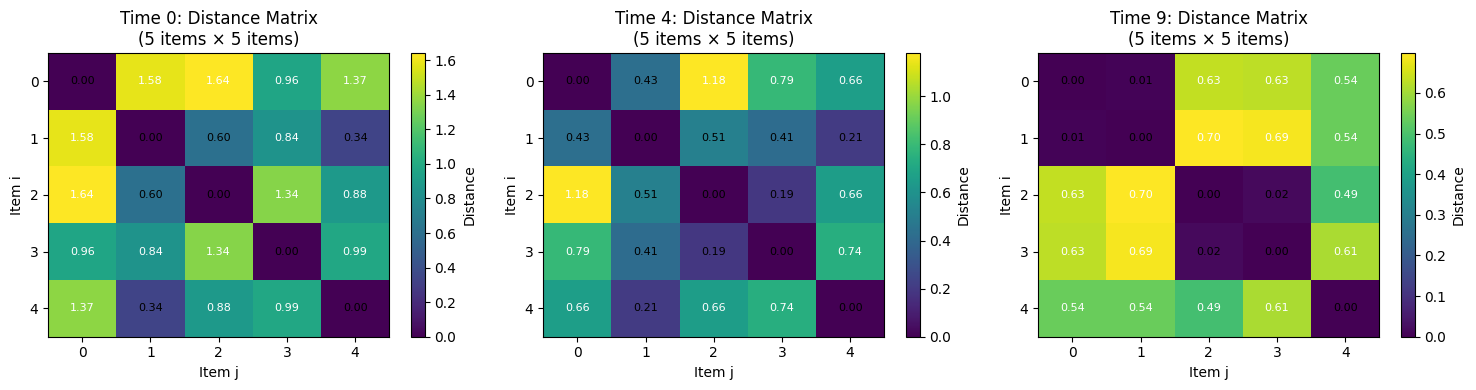


Explanation:
- Darker colors = smaller distances (more similar)
- Brighter colors = larger distances (more different)
- Diagonal is always 0 (item distance to itself)
- Notice how distances change over time as embeddings evolve!


In [25]:
# Compute distance matrices for a few time points
time_points_to_show = [0, 4, 9]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, t in enumerate(time_points_to_show):
    E_t = embeddings_time[:, t, :]  # Embeddings at time t
    D_t = frame_distance_matrix(E_t, metric='cosine')  # Distance matrix
    
    im = axes[idx].imshow(D_t, cmap='viridis', aspect='auto')
    axes[idx].set_title(f'Time {t}: Distance Matrix\n(5 items × 5 items)')
    axes[idx].set_xlabel('Item j')
    axes[idx].set_ylabel('Item i')
    plt.colorbar(im, ax=axes[idx], label='Distance')
    
    # Add text annotations
    for i in range(N):
        for j in range(N):
            axes[idx].text(j, i, f'{D_t[i, j]:.2f}', 
                          ha='center', va='center', 
                          color='white' if D_t[i, j] > D_t.max()/2 else 'black',
                          fontsize=8)

plt.tight_layout()
plt.show()

print("\nExplanation:")
print("- Darker colors = smaller distances (more similar)")
print("- Brighter colors = larger distances (more different)")
print("- Diagonal is always 0 (item distance to itself)")
print("- Notice how distances change over time as embeddings evolve!")


### Step 3: Compute MDS Coordinates Over Time

Now let's apply MDS to each time point and align them with Procrustes.


In [26]:
# Compute MDS coordinates for all time points
# Note: With N=5 items, we can have at most N-1=4 positive eigenvalues after centering
# So we use k_mds=4 to avoid dimension mismatch issues
# (The padding fix ensures consistent dimensions, but using k_mds <= N-1 is safer)
coords_2d = mds_movie_from_embeddings(
    embeddings_time=embeddings_time,
    metric='cosine',
    k_mds=4,        # Use 4 dimensions for MDS (max for 5 items, we'll visualize first 2)
    ref_t=5,        # Align all frames to time point 5 (middle)
    use_tqdm=True
)

print(f"\\nMDS coordinates shape: {coords_2d.shape}")
print(f"  - {coords_2d.shape[0]} items")
print(f"  - {coords_2d.shape[1]} time points")
print(f"  - {coords_2d.shape[2]} dimensions (2D for visualization)")


Computing MDS for 5 items over 10 time points...
Embedding dimension: 8, MDS dimensions: 4, Metric: cosine
Reference frame for alignment: 5


Procrustes alignment → ref 5: 100%|██████████| 10/10 [00:00<00:00, 12390.85it/s]


✓ MDS computation complete!
  Output shape: (5, 10, 2)
\nMDS coordinates shape: (5, 10, 2)
  - 5 items
  - 10 time points
  - 2 dimensions (2D for visualization)


### Step 4: Visualize How Items Move Over Time

Let's plot the trajectories of each item through the MDS space.


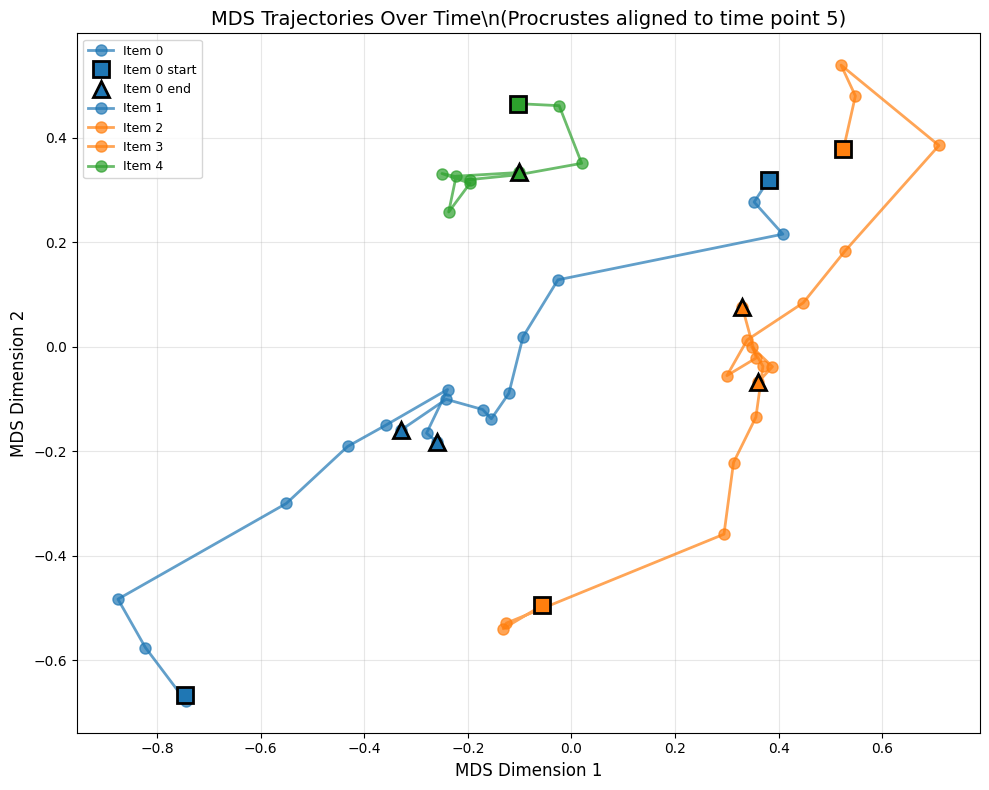

\nExplanation:
- Each line shows how one item moves through the 2D MDS space over time
- Square markers = starting position (time 0)
- Triangle markers = ending position (time 9)
- Notice how items 0-1 (blue) and items 2-3 (red) move together!
- This is because we made them converge in the embedding space
- Procrustes alignment ensures the coordinate system is consistent across time


In [30]:
# Create labels and colors for our 5 items
item_labels = ['Item 0', 'Item 1', 'Item 2', 'Item 3', 'Item 4']
# Color-code: items 0-1 are group A (blue), items 2-3 are group B (red), item 4 is group C (green)
item_colors = np.array([0, 0, 1, 1, 2])  # 0=blue, 1=red, 2=green

# Plot trajectories
fig, ax = plt.subplots(figsize=(10, 8))

# Plot trajectory for each item
for i in range(N):
    # Get trajectory for item i
    trajectory = coords_2d[i, :, :]  # Shape: (T, 2)
    
    # Plot the path
    ax.plot(trajectory[:, 0], trajectory[:, 1], 
           'o-', label=item_labels[i], 
           color=plt.cm.tab10(item_colors[i]),
           markersize=8, linewidth=2, alpha=0.7)
    
    # Mark start and end
    ax.plot(trajectory[0, 0], trajectory[0, 1], 
           's', markersize=12, color=plt.cm.tab10(item_colors[i]),
           markeredgecolor='black', markeredgewidth=2, label=f'{item_labels[i]} start' if i == 0 else '')
    ax.plot(trajectory[-1, 0], trajectory[-1, 1], 
           '^', markersize=12, color=plt.cm.tab10(item_colors[i]),
           markeredgecolor='black', markeredgewidth=2, label=f'{item_labels[i]} end' if i == 0 else '')

ax.set_xlabel('MDS Dimension 1', fontsize=12)
ax.set_ylabel('MDS Dimension 2', fontsize=12)
ax.set_title('MDS Trajectories Over Time\\n(Procrustes aligned to time point 5)', fontsize=14)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\\nExplanation:")
print("- Each line shows how one item moves through the 2D MDS space over time")
print("- Square markers = starting position (time 0)")
print("- Triangle markers = ending position (time 9)")
print("- Notice how items 0-1 (blue) and items 2-3 (red) move together!")
print("- This is because we made them converge in the embedding space")
print("- Procrustes alignment ensures the coordinate system is consistent across time")


### Step 5: Create the Animated Movie

Now let's create an animated movie showing how items move through the MDS space.


In [28]:
# Create the movie
movie_path = create_mds_movie(
    coords_2d=coords_2d,
    labels=item_labels,           # Show item labels
    colors=item_colors,            # Color-code by group
    outpath="dummy_mds_movie.gif",
    title="Dummy Example: MDS Movie",
    label_step=1,                  # Show all labels (we only have 5 items)
    figsize=(10, 8),
    slow_until=5,                  # Slow for first 5 frames
    slow_step=1,                   # Every frame in slow part
    fast_step=1,                   # Every frame in fast part (all frames since T=10)
    slow_interval=500,             # 500ms between frames (slow)
    fast_interval=300,             # 300ms between frames (faster)
    fps=5
)

print(f"\\n✓ Movie saved to: {movie_path}")
print("\\nThe movie shows:")
print("  - How items move through the 2D MDS space over time")
print("  - Color-coding: blue=group A, red=group B, green=group C")
print("  - Labels show which item is which")
print("  - Notice how similar items (same color) cluster together!")


Saving movie to dummy_mds_movie.gif...
✓ Movie saved successfully!
\n✓ Movie saved to: dummy_mds_movie.gif
\nThe movie shows:
  - How items move through the 2D MDS space over time
  - Color-coding: blue=group A, red=group B, green=group C
  - Labels show which item is which
  - Notice how similar items (same color) cluster together!


### Step 6: Compare Before and After Procrustes Alignment

Let's see why Procrustes alignment is important - it removes arbitrary rotations/translations.


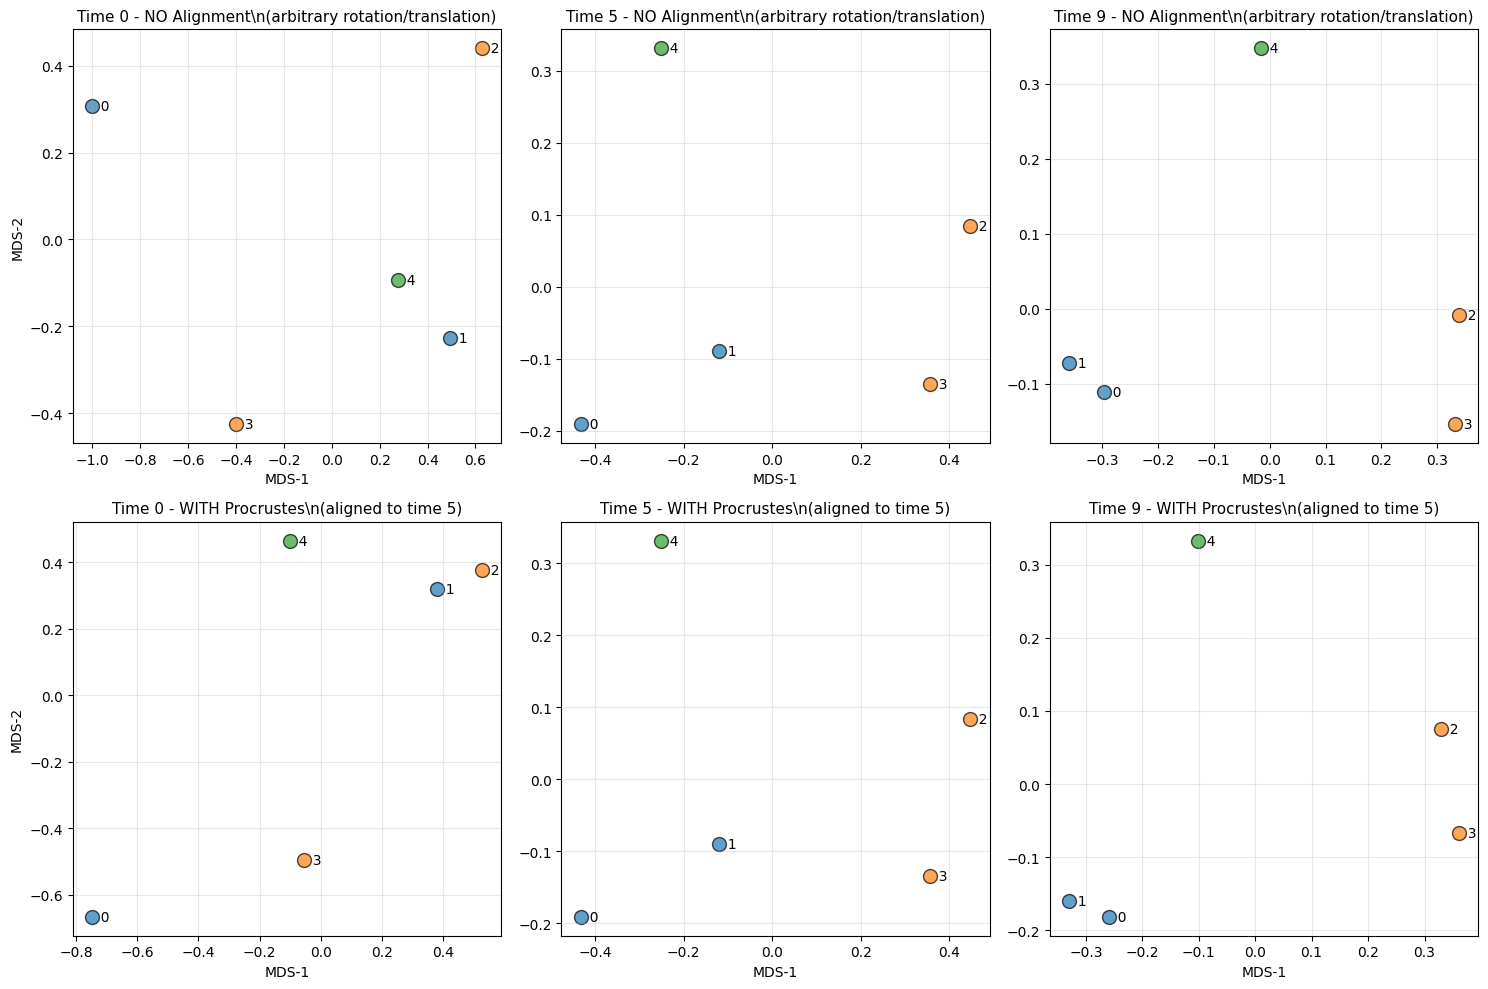

\nExplanation:
- Top row: MDS coordinates WITHOUT Procrustes alignment
  → Each time point has arbitrary rotation/translation
  → Hard to see how items move over time!
- Bottom row: MDS coordinates WITH Procrustes alignment
  → All frames aligned to reference frame (time 5)
  → Easy to see trajectories and how items move together!
  → The STRUCTURE (distances) is preserved, but coordinate system is consistent


In [29]:
# Compute MDS without Procrustes alignment (just for comparison)
coords_no_align = []
for t in range(T):
    E_t = embeddings_time[:, t, :]
    D_t = frame_distance_matrix(E_t, metric='cosine')
    X_t = classical_mds(D_t, n_components=2)  # Just 2D for visualization
    coords_no_align.append(X_t)
coords_no_align = np.stack(coords_no_align, axis=1)  # (N, T, 2)

# Compare: plot a few time points
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
time_points = [0, 5, 9]

for col, t in enumerate(time_points):
    # Without alignment
    ax = axes[0, col]
    for i in range(N):
        ax.scatter(coords_no_align[i, t, 0], coords_no_align[i, t, 1],
                  c=[plt.cm.tab10(item_colors[i])], s=100, alpha=0.7,
                  edgecolors='black', linewidth=1)
        ax.text(coords_no_align[i, t, 0], coords_no_align[i, t, 1],
               f'  {i}', fontsize=10, va='center')
    ax.set_title(f'Time {t} - NO Alignment\\n(arbitrary rotation/translation)', fontsize=11)
    ax.set_xlabel('MDS-1')
    if col == 0:
        ax.set_ylabel('MDS-2')
    ax.grid(True, alpha=0.3)
    
    # With Procrustes alignment
    ax = axes[1, col]
    for i in range(N):
        ax.scatter(coords_2d[i, t, 0], coords_2d[i, t, 1],
                  c=[plt.cm.tab10(item_colors[i])], s=100, alpha=0.7,
                  edgecolors='black', linewidth=1)
        ax.text(coords_2d[i, t, 0], coords_2d[i, t, 1],
               f'  {i}', fontsize=10, va='center')
    ax.set_title(f'Time {t} - WITH Procrustes\\n(aligned to time 5)', fontsize=11)
    ax.set_xlabel('MDS-1')
    if col == 0:
        ax.set_ylabel('MDS-2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\nExplanation:")
print("- Top row: MDS coordinates WITHOUT Procrustes alignment")
print("  → Each time point has arbitrary rotation/translation")
print("  → Hard to see how items move over time!")
print("- Bottom row: MDS coordinates WITH Procrustes alignment")
print("  → All frames aligned to reference frame (time 5)")
print("  → Easy to see trajectories and how items move together!")
print("  → The STRUCTURE (distances) is preserved, but coordinate system is consistent")


## Notes
